# Extract Figueroa 2009 methylation signature probes

In [65]:
library(gdata)
library(dplyr)
library(impute)
library(Heatplus)
library(pheatmap)
library(RColorBrewer)
library(viridis)

## There are 16 clusters of patients defined in Figueroa 2009. Methylation signature of each cluster was provided in [Table S3](https://www.cell.com/cms/attachment/1082556/7973036/mmc3.xls)

In [3]:
n <- 16
clusters <- list()
for (i in seq(n)) {
    clusters[[i]] <- read.xls('../data/mmc3.xls', sheet=i, skip=1, header=T, stringsAsFactor=F)
}

In [4]:
head(clusters[[16]])

HELP_ID,REFSEQ,GENE.SYMBOL,Status
MSPI0406S00055568,NM_016178,OAZ3,Hypermethylated
MSPI0406S00055568,NM_031420,MRPL9,Hypermethylated
MSPI0406S00062872,NM_015569,DNM3,Hypermethylated
MSPI0406S00069595,NM_006618,JARID1B,Hypermethylated
MSPI0406S00083922,NM_014322,OPN3,Hypermethylated
MSPI0406S00099987,NM_173853,KRTCAP3,Hypermethylated


In [5]:
cluster.probes <- list()
for (i in seq(n)) {
    probe.names <- unique(clusters[[i]]$GENE.SYMBOL)
    cluster.probes[[i]] <- probe.names[probe.names!='']
}

In [6]:
sum(unlist(lapply(cluster.probes, length)))

[1] 2719

In [7]:
length(unique(unlist(cluster.probes)))

[1] 944

In [16]:
# save probes as separate tsv files
for (i in seq(n)) {
    write.table(cluster.probes[[i]], file=paste0('../data/Figueroa/cluster', i, '.tsv'), sep='\t', quote=F, row.names=F, col.names=F)
}

## Preprocess TCGA LAML HM27 array
- keep probes on autosomes
- remove rows with missingness > 50 %
- impute missing values using KNN

In the end there are 22486 probes left.

In [8]:
in.file <- "/oak/stanford/groups/andrewg/users/szmamie/repos/MethylationPrediction/data/LAML/HM27/LAML.methylation__humanmethylation27__jhu_usc_edu__Level_3__within_bioassay_data_set_function__data.data.txt"
data.HM27 <- read.csv(in.file, sep='\t', header=T, stringsAsFactors=F)

In [9]:
head(data.HM27)

Hybridization.REF,TCGA.AB.2802.03A.01D.0741.05,TCGA.AB.2802.03A.01D.0741.05.1,TCGA.AB.2802.03A.01D.0741.05.2,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2803.03A.01D.0741.05.1,TCGA.AB.2803.03A.01D.0741.05.2,TCGA.AB.2803.03A.01D.0741.05.3,TCGA.AB.2804.03A.01D.0741.05,⋯,TCGA.AB.3009.03A.01D.0741.05.2,TCGA.AB.3009.03A.01D.0741.05.3,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3011.03A.01D.0742.05.1,TCGA.AB.3011.03A.01D.0742.05.2,TCGA.AB.3011.03A.01D.0742.05.3,TCGA.AB.3012.03A.01D.0741.05,TCGA.AB.3012.03A.01D.0741.05.1,TCGA.AB.3012.03A.01D.0741.05.2,TCGA.AB.3012.03A.01D.0741.05.3
Composite Element REF,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,⋯,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate,Beta_value,Gene_Symbol,Chromosome,Genomic_Coordinate
cg00000292,0.861564594389913,ATP2A1,16,28890100,0.869796254327262,ATP2A1,16,28890100,0.659263617015686,⋯,16,28890100,0.928697049000533,ATP2A1,16,28890100,0.776383029009759,ATP2A1,16,28890100
cg00002426,0.946342497027903,SLMAP,3,57743543,0.956351509562422,SLMAP,3,57743543,0.952163188492067,⋯,3,57743543,0.943344882215032,SLMAP,3,57743543,0.958471471600558,SLMAP,3,57743543
cg00003994,0.125274641595058,MEOX2,7,15725862,0.0328039420364536,MEOX2,7,15725862,0.0198515878808095,⋯,7,15725862,0.0432628171713411,MEOX2,7,15725862,0.0241999405267976,MEOX2,7,15725862
cg00005847,0.0598080004964315,HOXD3,2,177029073,0.07380597656889,HOXD3,2,177029073,0.0759276258088186,⋯,2,177029073,0.0619550401824966,HOXD3,2,177029073,0.483870393824195,HOXD3,2,177029073
cg00006414,NA,ZNF425;ZNF398,7,148822837,NA,ZNF425;ZNF398,7,148822837,NA,⋯,7,148822837,NA,ZNF425;ZNF398,7,148822837,NA,ZNF425;ZNF398,7,148822837


In [10]:
# remove duplicate columns
num.columns <- dim(data.HM27)[2]
redundant.idx <- c(seq(7, num.columns, by=4), seq(8, num.columns, by=4),
                   seq(9, num.columns, by=4))
data.HM27 <- data.HM27[-1,-redundant.idx] # remove duplicate columns and the subheader

In [11]:
data.HM27[,seq(5)] <- data.HM27[,c(1,3,4,5,2)]
columnnames <- colnames(data.HM27)
columnnames[seq(4)] <- c('ID', 'Gene.Symbol', 'Chromosome', 'Genomic.Coordinate')

In [12]:
colnames(data.HM27) <- columnnames
head(data.HM27)

,ID,Gene.Symbol,Chromosome,Genomic.Coordinate,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
2,cg00000292,ATP2A1,16,28890100,0.861564594389913,0.869796254327262,0.659263617015686,0.932946724632718,0.434150957621834,0.928195228689417,⋯,0.83005568466969,0.822909899344701,0.896799579299195,0.116586283587051,0.803471817822614,0.755601291503743,0.8376730984871,0.874428168920322,0.928697049000533,0.776383029009759
3,cg00002426,SLMAP,3,57743543,0.946342497027903,0.956351509562422,0.952163188492067,0.944987302521737,0.960404867712641,0.910392613236136,⋯,0.954125833073063,0.904435458531103,0.854480226555902,0.907178257587787,0.95398285797124,0.955507212862314,0.943963876160918,0.0914740039517164,0.943344882215032,0.958471471600558
4,cg00003994,MEOX2,7,15725862,0.125274641595058,0.0328039420364536,0.0198515878808095,0.0611239926405519,0.701073431514385,0.323642434664094,⋯,0.0676724573176588,0.0641117583780573,0.164212889387799,0.044640912422344,0.0263884798629089,0.0394962364556658,0.126589731612399,0.780510713213238,0.0432628171713411,0.0241999405267976
5,cg00005847,HOXD3,2,177029073,0.0598080004964315,0.07380597656889,0.0759276258088186,0.418507583461411,0.578411542720016,0.0622155841391899,⋯,0.0987722054558421,0.419468490515621,0.0722420125364288,0.0450166849393871,0.405852511062285,0.0498983050892556,0.413694628901505,0.843740668771244,0.0619550401824966,0.483870393824195
6,cg00006414,ZNF425;ZNF398,7,148822837,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,cg00007981,PANX1,11,93862594,0.0215376632808789,0.0196252163995875,0.0276856671415462,0.0201775775125595,0.0165949846691597,0.0246986033158712,⋯,0.0278169104575322,0.021802428840714,0.0491109694610346,0.0247554209860639,0.0299209972718848,0.0203239370900496,0.0264614106898471,0.0235354854469433,0.0307930650695307,0.0218305446674515


In [13]:
dim(data.HM27) # original data size

[1] 27578   198

In [14]:
print(unique(data.HM27$Chromosome))

 [1] "16" "3"  "7"  "2"  "11" "14" "18" NA   "1"  "6"  "22" "12" "4"  "17" "20"
[16] "10" "X"  "19" "9"  "13" "8"  "5"  "15" "21" "Y" 


In [15]:
# remove X, Y, NA chromosome 
data.HM27 <- data.HM27 %>%
  dplyr::filter(!(Chromosome %in% c("X", "Y", NA)))

In [16]:
dim(data.HM27) # keep only autosomal probes

[1] 25014   198

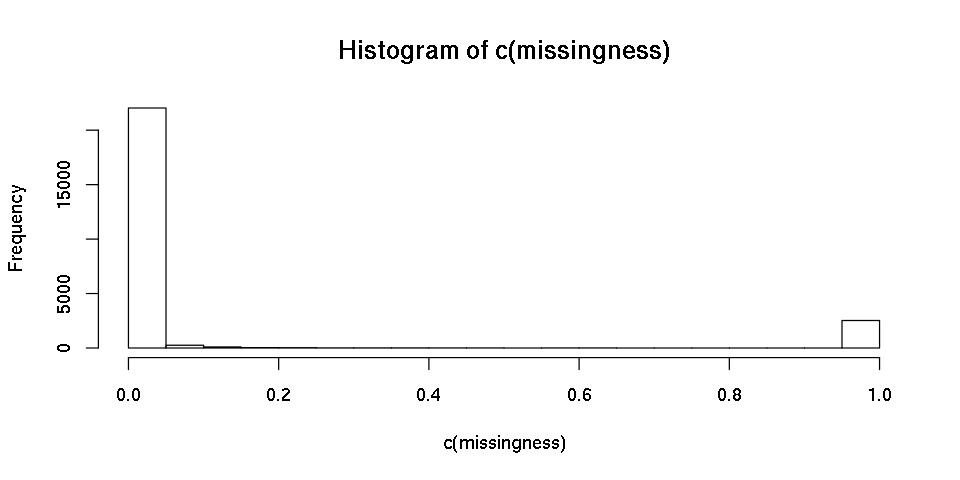

In [17]:
# remove rows with missingness > 10 % and impute missing beta values 
options(repr.plot.width=8, repr.plot.height=4)
missingness <- apply(data.HM27[,-seq(4)], 1, function(x) mean(is.na(x)))
hist(c(missingness), breaks=30)

In [18]:
sum(missingness >= 0.5) # 2528 rows to remove with > 0.5 missingness

[1] 2528

In [19]:
data.HM27 <- data.HM27[missingness < 0.5,]
dim(data.HM27) # remove missing probes

[1] 22486   198

In [20]:
head(data.HM27)

,ID,Gene.Symbol,Chromosome,Genomic.Coordinate,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
1,cg00000292,ATP2A1,16,28890100,0.861564594389913,0.869796254327262,0.659263617015686,0.932946724632718,0.434150957621834,0.928195228689417,⋯,0.83005568466969,0.822909899344701,0.896799579299195,0.116586283587051,0.803471817822614,0.755601291503743,0.8376730984871,0.874428168920322,0.928697049000533,0.776383029009759
2,cg00002426,SLMAP,3,57743543,0.946342497027903,0.956351509562422,0.952163188492067,0.944987302521737,0.960404867712641,0.910392613236136,⋯,0.954125833073063,0.904435458531103,0.854480226555902,0.907178257587787,0.95398285797124,0.955507212862314,0.943963876160918,0.0914740039517164,0.943344882215032,0.958471471600558
3,cg00003994,MEOX2,7,15725862,0.125274641595058,0.0328039420364536,0.0198515878808095,0.0611239926405519,0.701073431514385,0.323642434664094,⋯,0.0676724573176588,0.0641117583780573,0.164212889387799,0.044640912422344,0.0263884798629089,0.0394962364556658,0.126589731612399,0.780510713213238,0.0432628171713411,0.0241999405267976
4,cg00005847,HOXD3,2,177029073,0.0598080004964315,0.07380597656889,0.0759276258088186,0.418507583461411,0.578411542720016,0.0622155841391899,⋯,0.0987722054558421,0.419468490515621,0.0722420125364288,0.0450166849393871,0.405852511062285,0.0498983050892556,0.413694628901505,0.843740668771244,0.0619550401824966,0.483870393824195
6,cg00007981,PANX1,11,93862594,0.0215376632808789,0.0196252163995875,0.0276856671415462,0.0201775775125595,0.0165949846691597,0.0246986033158712,⋯,0.0278169104575322,0.021802428840714,0.0491109694610346,0.0247554209860639,0.0299209972718848,0.0203239370900496,0.0264614106898471,0.0235354854469433,0.0307930650695307,0.0218305446674515
7,cg00008493,COX8C;KIAA1409,14,93813777,0.981396555005453,0.981749684415936,0.98403200299398,0.986814081141049,0.985375369737061,0.981171686729287,⋯,0.986511791525834,0.975793228408668,0.981439717909794,0.983013757322295,0.985596206515573,0.985931551668339,0.985511914327982,0.98634041766771,0.984950726081008,0.984399675867947


In [21]:
data.HM27.imputed <- impute.knn(data.matrix(data.HM27[-seq(4)]), k = 10, rowmax = 0.5, colmax = 0.8, maxp = 1500, rng.seed=362436069) # impute using KNN

Cluster size 22486 broken into 16374 6112 
Cluster size 16374 broken into 2768 13606 
Cluster size 2768 broken into 1057 1711 
Done cluster 1057 
Cluster size 1711 broken into 685 1026 
Done cluster 685 
Done cluster 1026 
Done cluster 1711 
Done cluster 2768 
Cluster size 13606 broken into 11025 2581 
Cluster size 11025 broken into 2683 8342 
Cluster size 2683 broken into 353 2330 
Done cluster 353 
Cluster size 2330 broken into 647 1683 
Done cluster 647 
Cluster size 1683 broken into 373 1310 
Done cluster 373 
Done cluster 1310 
Done cluster 1683 
Done cluster 2330 
Done cluster 2683 
Cluster size 8342 broken into 5354 2988 
Cluster size 5354 broken into 2694 2660 
Cluster size 2694 broken into 89 2605 
Done cluster 89 
Cluster size 2605 broken into 2599 6 
Cluster size 2599 broken into 2272 327 
Cluster size 2272 broken into 1365 907 
Done cluster 1365 
Done cluster 907 
Done cluster 2272 
Done cluster 327 
Done cluster 2599 
Done cluster 6 
Done cluster 2605 
Done cluster 2694 
C

In [22]:
head(data.HM27.imputed$data)

,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
1,0.86156459,0.86979625,0.65926362,0.93294672,0.43415096,0.92819523,0.78032215,0.59317697,0.94480293,0.58047182,⋯,0.83005568,0.82290990,0.89679958,0.11658628,0.80347182,0.75560129,0.83767310,0.87442817,0.92869705,0.77638303
2,0.94634250,0.95635151,0.95216319,0.94498730,0.96040487,0.91039261,0.92129838,0.91930527,0.95642581,0.93849838,⋯,0.95412583,0.90443546,0.85448023,0.90717826,0.95398286,0.95550721,0.94396388,0.09147400,0.94334488,0.95847147
3,0.12527464,0.03280394,0.01985159,0.06112399,0.70107343,0.32364243,0.04443957,0.02832298,0.02952006,0.01792710,⋯,0.06767246,0.06411176,0.16421289,0.04464091,0.02638848,0.03949624,0.12658973,0.78051071,0.04326282,0.02419994
4,0.05980800,0.07380598,0.07592763,0.41850758,0.57841154,0.06221558,0.07963455,0.04705453,0.04435912,0.03485283,⋯,0.09877221,0.41946849,0.07224201,0.04501668,0.40585251,0.04989831,0.41369463,0.84374067,0.06195504,0.48387039
6,0.02153766,0.01962522,0.02768567,0.02017758,0.01659498,0.02469860,0.03145926,0.02087033,0.02540435,0.02989397,⋯,0.02781691,0.02180243,0.04911097,0.02475542,0.02992100,0.02032394,0.02646141,0.02353549,0.03079307,0.02183054
7,0.98139656,0.98174968,0.98403200,0.98681408,0.98537537,0.98117169,0.97975446,0.98762202,0.98431479,0.98766407,⋯,0.98651179,0.97579323,0.98143972,0.98301376,0.98559621,0.98593155,0.98551191,0.98634042,0.98495073,0.98439968


In [23]:
HM27.processed <- data.HM27.imputed$data
rownames(HM27.processed) <- c(data.HM27$Gene.Symbol)

In [24]:
head(HM27.processed)

,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
ATP2A1,0.86156459,0.86979625,0.65926362,0.93294672,0.43415096,0.92819523,0.78032215,0.59317697,0.94480293,0.58047182,⋯,0.83005568,0.82290990,0.89679958,0.11658628,0.80347182,0.75560129,0.83767310,0.87442817,0.92869705,0.77638303
SLMAP,0.94634250,0.95635151,0.95216319,0.94498730,0.96040487,0.91039261,0.92129838,0.91930527,0.95642581,0.93849838,⋯,0.95412583,0.90443546,0.85448023,0.90717826,0.95398286,0.95550721,0.94396388,0.09147400,0.94334488,0.95847147
MEOX2,0.12527464,0.03280394,0.01985159,0.06112399,0.70107343,0.32364243,0.04443957,0.02832298,0.02952006,0.01792710,⋯,0.06767246,0.06411176,0.16421289,0.04464091,0.02638848,0.03949624,0.12658973,0.78051071,0.04326282,0.02419994
HOXD3,0.05980800,0.07380598,0.07592763,0.41850758,0.57841154,0.06221558,0.07963455,0.04705453,0.04435912,0.03485283,⋯,0.09877221,0.41946849,0.07224201,0.04501668,0.40585251,0.04989831,0.41369463,0.84374067,0.06195504,0.48387039
PANX1,0.02153766,0.01962522,0.02768567,0.02017758,0.01659498,0.02469860,0.03145926,0.02087033,0.02540435,0.02989397,⋯,0.02781691,0.02180243,0.04911097,0.02475542,0.02992100,0.02032394,0.02646141,0.02353549,0.03079307,0.02183054
COX8C;KIAA1409,0.98139656,0.98174968,0.98403200,0.98681408,0.98537537,0.98117169,0.97975446,0.98762202,0.98431479,0.98766407,⋯,0.98651179,0.97579323,0.98143972,0.98301376,0.98559621,0.98593155,0.98551191,0.98634042,0.98495073,0.98439968


In [25]:
dim(HM27.processed)

[1] 22486   194

In [28]:
sum(duplicated(rownames(HM27.processed))) # number of unique genes in the filtered array are 9328

[1] 9328

In [27]:
write.table(HM27.processed, file='../data/LAML/processed/HM27-imputed.tsv', sep='\t', row.names=T, col.names=T, quote=F)

## Find corresponding probes in the Figueroa paper

In [29]:
findIdx <- function(probe.name) which(grepl(paste0(probe.name, '$|', probe.name, ';'), rownames(HM27.processed), fixed=F))
FindIdx <- Vectorize(findIdx)                              
res <- FindIdx(cluster.probes[[1]])

### there are more than one probes matching each gene in the cluster

In [30]:
print(str(res)) # Figueroa cluster 1 genes in HM27

List of 173
 $ PHF13        : int [1:2] 5491 6987
 $ HNRPR        : int(0) 
 $ HNRNPR       : int [1:2] 1464 5200
 $ TIE1         : int(0) 
 $ SYDE2        : int(0) 
 $ THEM4        : int [1:2] 3220 5677
 $ FCRLB        : int [1:2] 21193 22354
 $ DNM3         : int [1:2] 826 19061
 $ ZNF281       : int [1:2] 7474 14637
 $ MRPL55       : int [1:2] 6687 7642
 $ LBX2         : int(0) 
 $ SDPR         : int [1:2] 5121 11747
 $ ICA1L        : int [1:3] 8842 11679 21634
 $ ZNF662       : int 21602
 $ CISH         : int [1:2] 5755 7252
 $ FSTL1        : int [1:2] 16396 18321
 $ TXNRD3       : int(0) 
 $ PFN2         : int [1:2] 2371 19762
 $ GPR149       : int(0) 
 $ PIGZ         : int [1:2] 775 4809
 $ CCDC96       : int [1:2] 3082 7604
 $ MGC21874     : int(0) 
 $ CXCL1        : int [1:2] 1662 21017
 $ EREG         : int [1:2] 4038 15747
 $ TLR2         : int [1:2] 5364 15529
 $ DKFZP686E2158: int(0) 
 $ CRHBP        : int [1:2] 13535 17815
 $ NEUROG1      : int [1:5] 3535 4012 9095 9669 12

# Convert to M value to have better statistical behavior

\begin{align}
\beta &= \frac{2^M}{2^M + 1} \\
M &= \log_2 \frac{\beta}{1 - \beta}
\end{align}

In [34]:
beta2M <- function(beta) {
    log(beta/(1 - beta), base=2)
}
Beta2M <- Vectorize(beta2M)

In [41]:
HM27.processed <- apply(HM27.processed, 2, Beta2M)

In [42]:
write.table(HM27.processed, file='../data/LAML/processed/HM27-imputed-Mvalue.tsv', sep='\t', row.names=T, col.names=T, quote=F)

In [43]:
head(HM27.processed)

,TCGA.AB.2802.03A.01D.0741.05.3,TCGA.AB.2803.03A.01D.0741.05,TCGA.AB.2804.03A.01D.0741.05,TCGA.AB.2805.03A.01D.0741.05,TCGA.AB.2806.03A.01D.0741.05,TCGA.AB.2807.03A.01D.0741.05,TCGA.AB.2808.03A.01D.0741.05,TCGA.AB.2809.03A.01D.0741.05,TCGA.AB.2810.03A.01D.0741.05,TCGA.AB.2811.03A.01D.0741.05,⋯,TCGA.AB.3000.03A.01D.0741.05,TCGA.AB.3001.03A.01D.0741.05,TCGA.AB.3002.03A.01D.0742.05,TCGA.AB.3005.03A.01D.0741.05,TCGA.AB.3006.03A.01D.0741.05,TCGA.AB.3007.03A.01D.0741.05,TCGA.AB.3008.03A.01D.0741.05,TCGA.AB.3009.03A.01D.0741.05,TCGA.AB.3011.03A.01D.0742.05,TCGA.AB.3012.03A.01D.0741.05
ATP2A1,2.637746,2.739907,0.9521995,3.7984150,-0.3822205,3.692277,1.828680,0.5440612,4.097350,0.4684583,⋯,2.288146,2.2162509,3.119337,-2.921691,2.0315112,1.628389,2.367485,2.799827,3.703174,1.79573890
SLMAP,4.140511,4.453537,4.3150157,4.1024584,4.6002477,3.344799,3.549203,3.5099977,4.456107,3.9316580,⋯,4.378426,3.2424702,2.553832,3.288851,4.3737201,4.424623,4.074303,-3.312094,4.057507,4.52856084
MEOX2,-2.803736,-4.881867,-5.6256739,-3.9411240,1.2297744,-1.063385,-4.426431,-5.1004320,-5.038931,-5.7756161,⋯,-3.784196,-3.8676754,-2.347568,-4.419605,-5.2053661,-4.604004,-2.786499,1.830268,-4.466923,-5.33351016
HOXD3,-3.974545,-3.649505,-3.6053090,-0.4745066,0.4562610,-3.913908,-3.530740,-4.3399881,-4.429166,-4.7914013,⋯,-3.189715,-0.4688119,-3.682839,-4.406944,-0.5498656,-4.251019,-0.503086,2.432857,-3.920364,-0.09311272
PANX1,-5.505583,-5.642553,-5.1342116,-5.6016954,-5.8889665,-5.303347,-4.944256,-5.5519745,-5.261656,-5.0202161,⋯,-5.127194,-5.4875651,-4.275160,-5.299948,-5.0188721,-5.591053,-5.201276,-5.374658,-4.976127,-5.48566438
COX8C;KIAA1409,5.721194,5.749362,5.9454500,6.2257083,6.0742014,5.703530,5.596744,6.3181113,5.971643,6.3230816,⋯,6.192566,5.3330929,5.724609,5.854773,6.0964760,6.130952,6.087934,6.174100,6.032286,5.97959627


In [80]:
PlotHeatmap <- function(i) {
    idx <- FindIdx(cluster.probes[[i]])
    options(repr.plot.width=6, repr.plot.height=6)
    pheatmap(
      mat               = HM27.processed[unlist(idx),],
      color             = inferno(20),
      border_color      = NA,
      show_colnames     = FALSE,
      show_rownames     = FALSE,
      fontsize          = 14,
      main              = paste0("cluster ", i)
    )
}

## Figueroa cluster 1 in TCGA

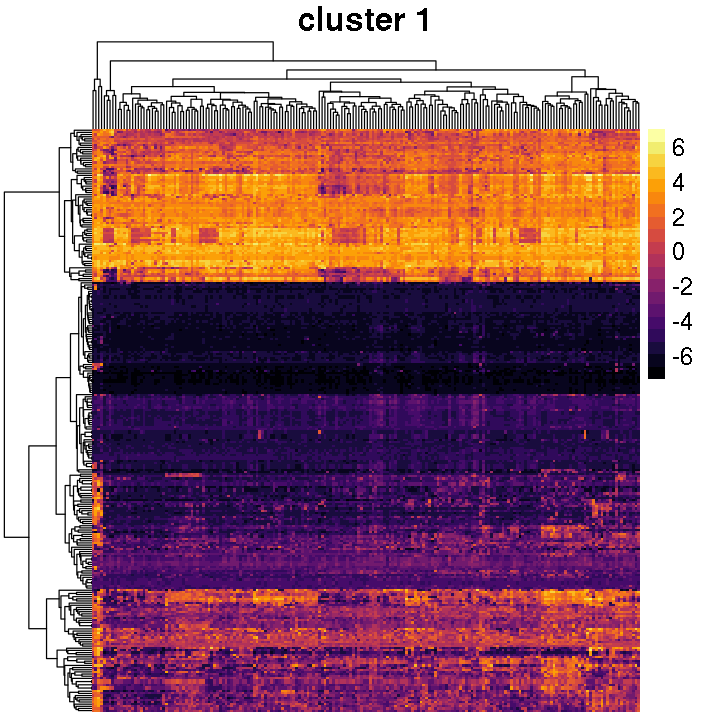

In [81]:
PlotHeatmap(1)

## patients are columns and probes are rows. It doesn't quite looks like a single cluster of probes. same goes for the rest of the clusters

## cluster 2

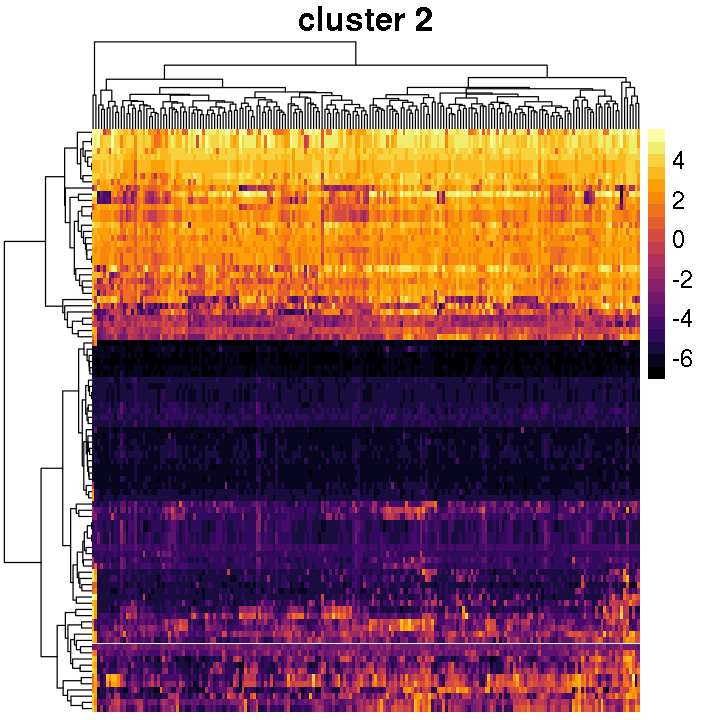

In [82]:
PlotHeatmap(2)

## cluster 3

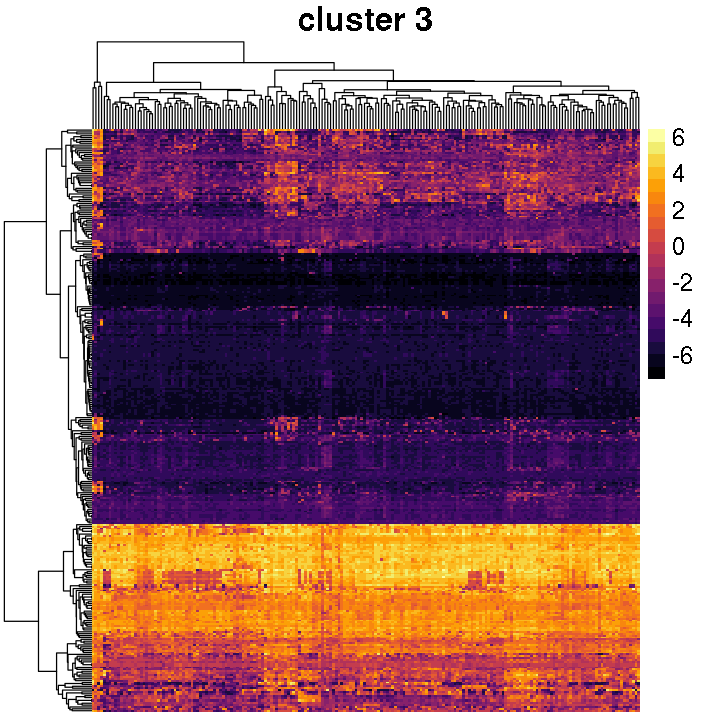

In [83]:
PlotHeatmap(3)

# Clustering on all probes from Figueroa clusters and 7 clusters on probes end up with a reasonable number of probes in each cluster

In [56]:
cluster.probes.all <- unique(unlist(cluster.probes))
idx <- FindIdx(cluster.probes.all)

In [58]:
probe.idx <- c(unlist(idx))
length(probe.idx)

[1] 1470

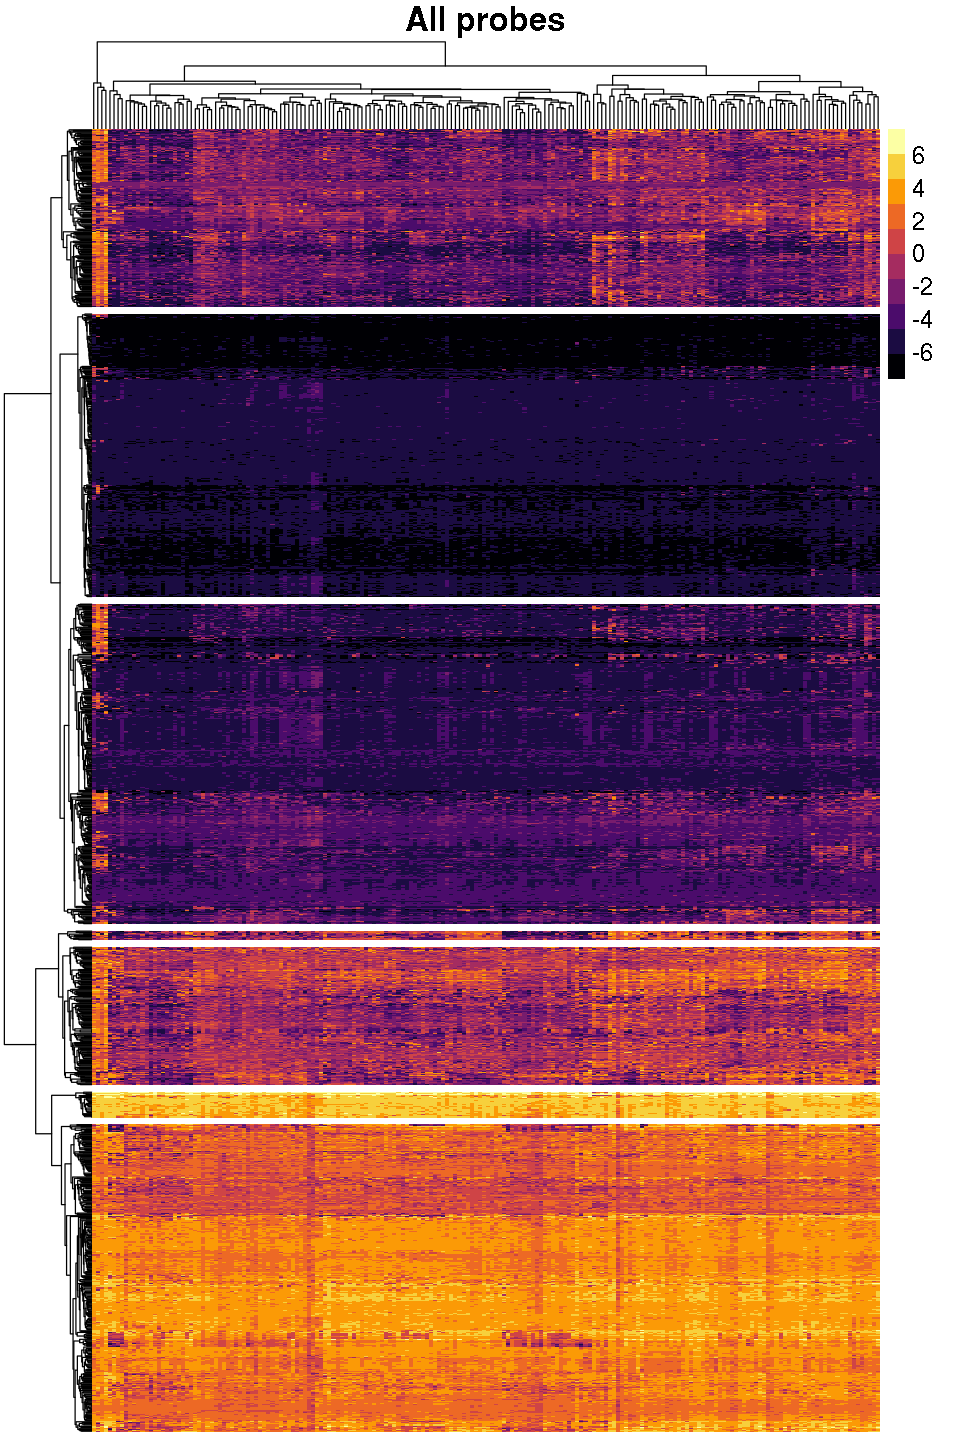

In [95]:
options(repr.plot.width=8, repr.plot.height=12)

pheatmap(
  mat               = HM27.processed[probe.idx,],
  color             = inferno(10),
  border_color      = NA,
  show_colnames     = FALSE,
  show_rownames     = FALSE,
  fontsize          = 14,
  cutree_rows       = 7,
  main              = "All probes"
)

## Save Figueroa cluster methylation matrix for vbsr analysis

In [85]:
write.table(HM27.processed[probe.idx,], file='../data/LAML/processed/Figueroa-HM27-imputed-M.tsv', sep='\t', quote=F, row.names=T, col.names=T)